In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("crush_data_v1.csv",low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.groupby('Driver At Fault')['Person ID'].agg('count')

Driver At Fault
No         74900
Unknown     4699
Yes        92405
Name: Person ID, dtype: int64

# Features Selection

In [5]:
feature_columns = ['ACRS Report Type','Collision Type',
                   'Driver Distracted By','Vehicle Damage Extent',
                    'Vehicle Movement','Speed Limit','Vehicle Year','Driver Substance Abuse']

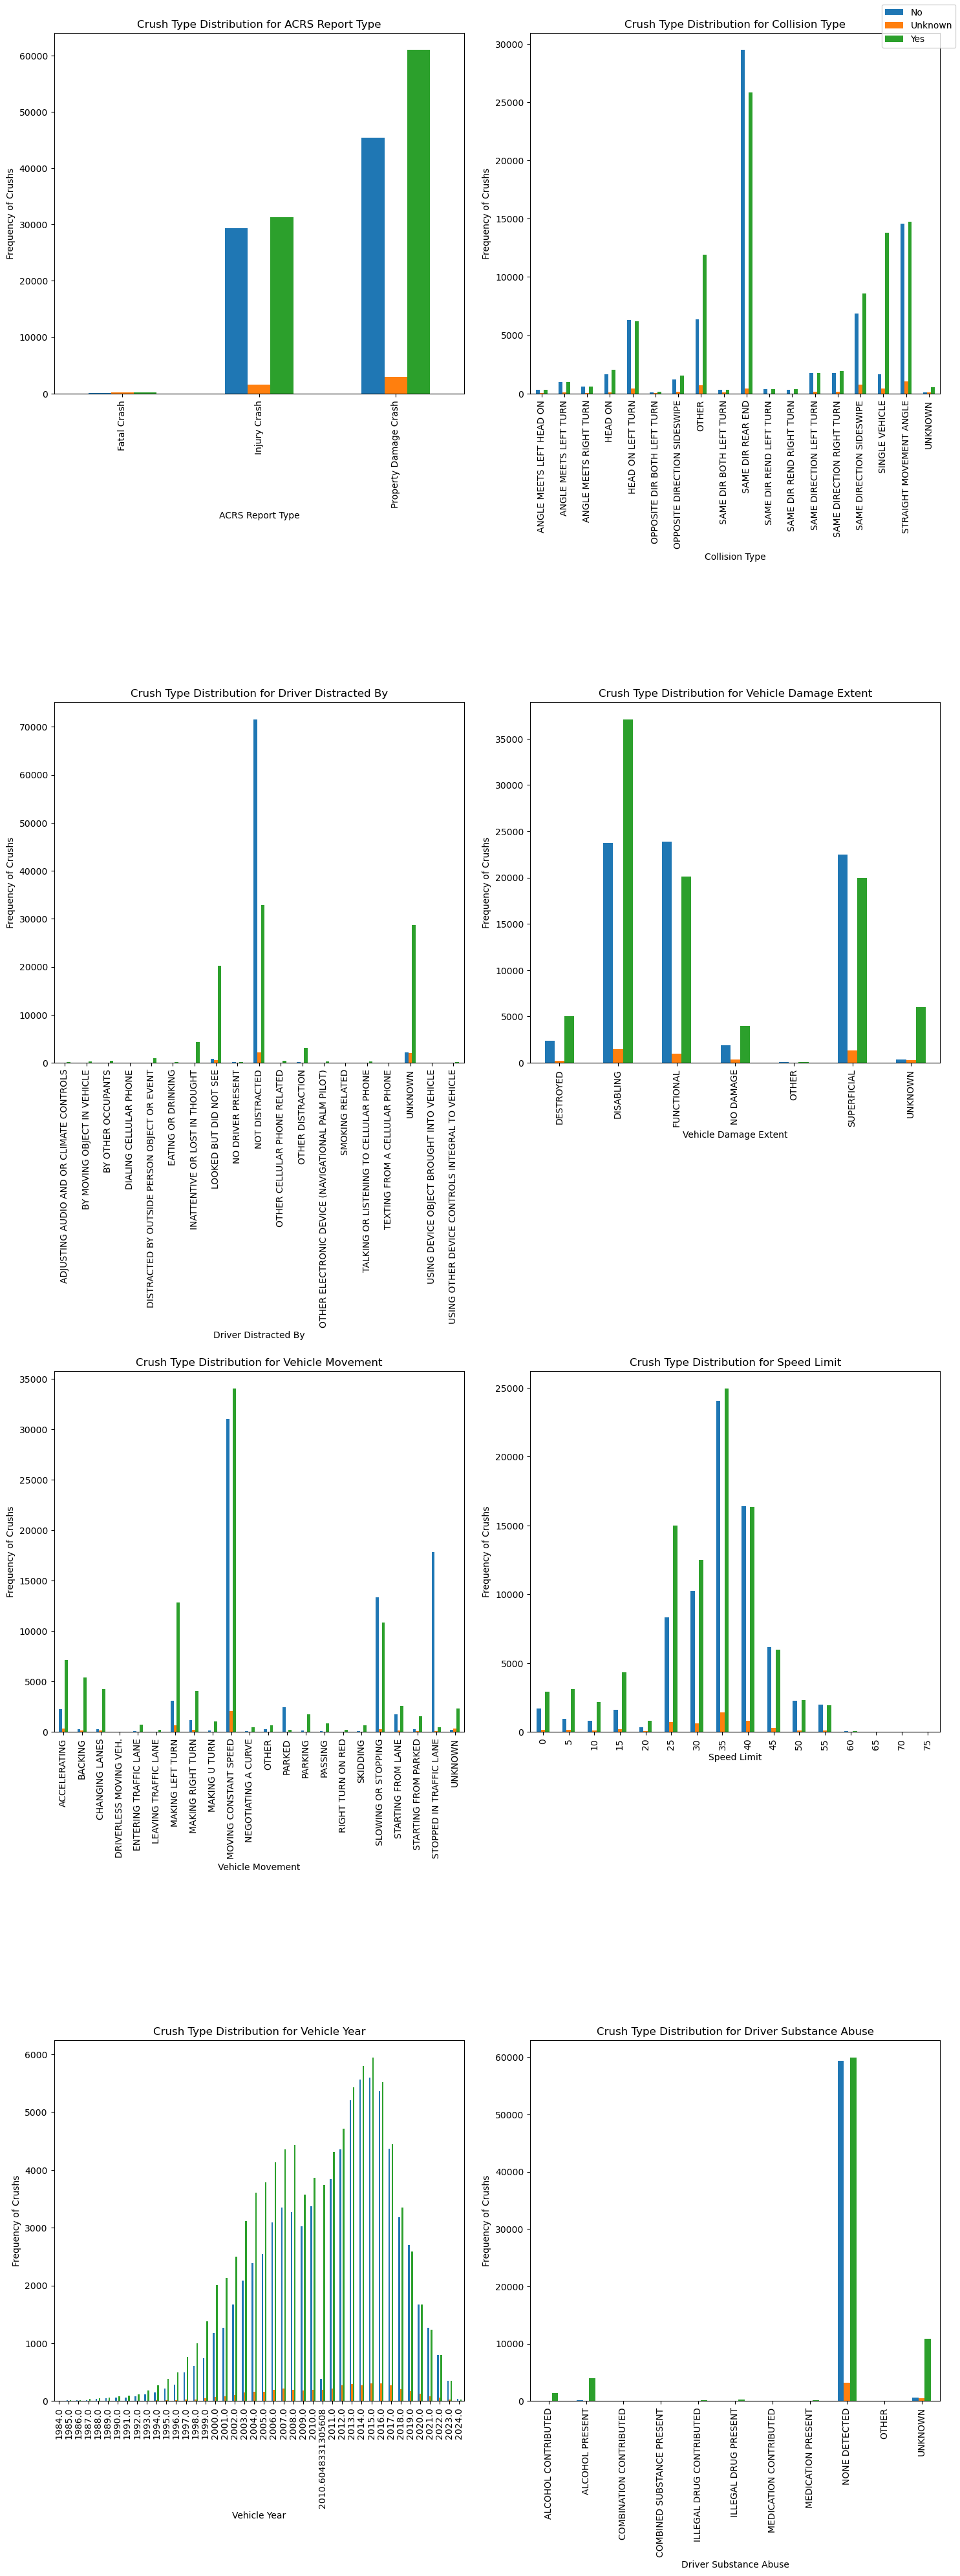

In [6]:
num_columns = 2
num_rows = (len(feature_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 40))

axes = axes.flatten()

legend_handles, legend_labels = None, None

for i, feature in enumerate(feature_columns):

    cross_tab = pd.crosstab(df[feature], df['Driver At Fault'])
    
    ax = cross_tab.plot(kind='bar', ax=axes[i], legend=False)

    ax.set_title(f'Crush Type Distribution for {feature}')

    ax.set_xlabel(feature)

    ax.set_ylabel('Frequency of Crushs')

    if i == 0:
        legend_handles, legend_labels = ax.get_legend_handles_labels()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.0)

fig.legend(legend_handles, legend_labels, loc='upper right')

plt.show()


# Data Cleaning and Prepearation

In [7]:
DAFP_Data = df[feature_columns]

DAFP_Data = pd.concat([DAFP_Data,df['Driver At Fault']], axis=1)

DAFP_Data = DAFP_Data[DAFP_Data['Driver At Fault'] != 'Unknown']

DAFP_Data['Driver At Fault'].replace('Yes','1',inplace=True)
DAFP_Data['Driver At Fault'].replace('No','0',inplace=True)
DAFP_Data['Driver At Fault'] = DAFP_Data['Driver At Fault'].astype(int)

In [8]:
DAFP_Data.dtypes

ACRS Report Type           object
Collision Type             object
Driver Distracted By       object
Vehicle Damage Extent      object
Vehicle Movement           object
Speed Limit                 int64
Vehicle Year              float64
Driver Substance Abuse     object
Driver At Fault             int32
dtype: object

In [9]:
DAFP_Data['Driver Substance Abuse'].replace(['COMBINED SUBSTANCE PRESENT','ILLEGAL DRUG PRESENT','ILLEGAL DRUG CONTRIBUTED','MEDICATION CONTRIBUTED','MEDICATION PRESENT','COMBINATION CONTRIBUTED'], 'OTHER',inplace=True)

In [10]:
DAFP_Data['Driver Substance Abuse'].fillna('UNKNOWN',inplace=True)

Text(0, 0.5, 'Frequency of Crushes')

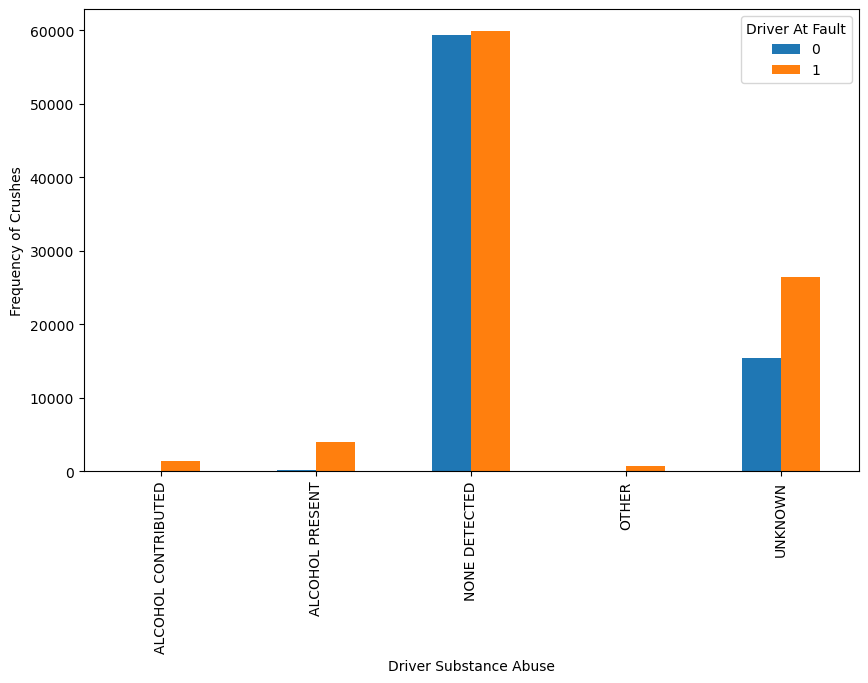

In [11]:
pd.crosstab(DAFP_Data['Driver Substance Abuse'],DAFP_Data['Driver At Fault']).plot(kind='bar',figsize=(10,6))
plt.xlabel('Driver Substance Abuse')
plt.ylabel('Frequency of Crushes')

In [12]:
list_1 = list(DAFP_Data['Driver Distracted By'].unique())

In [13]:
list_1.remove('UNKNOWN')
list_1.remove('NOT DISTRACTED')

In [14]:
DAFP_Data['Driver Distracted By'].replace(list_1, 'DISTRACTED',inplace=True)

Text(0, 0.5, 'Frequency of Crushes')

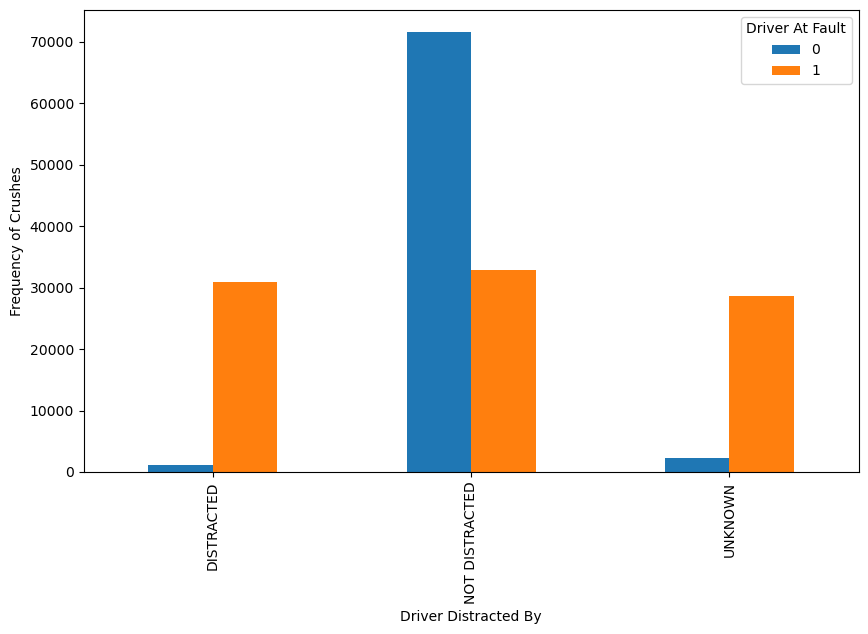

In [15]:
pd.crosstab(DAFP_Data['Driver Distracted By'],DAFP_Data['Driver At Fault']).plot(kind='bar',figsize=(10,6))
plt.xlabel('Driver Distracted By')
plt.ylabel('Frequency of Crushes')

In [16]:
DAFP_Data.isnull().sum()

ACRS Report Type            0
Collision Type            550
Driver Distracted By        0
Vehicle Damage Extent     295
Vehicle Movement          364
Speed Limit                 0
Vehicle Year                0
Driver Substance Abuse      0
Driver At Fault             0
dtype: int64

In [17]:
data = DAFP_Data[feature_columns]

data = pd.get_dummies(data)

features = data.columns

data = pd.concat([data,DAFP_Data['Driver At Fault']], axis=1)

# Designing the models

In [18]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [19]:
def modelfit(alg, X, y, performCV=True, printFeatureImportance=False, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    y_pred = alg.predict(X)
    y_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, y_pred))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    
    if printFeatureImportance:
        
        # Get feature importances from the model
        feature_importances = alg.feature_importances_

        # Get the names of the features
        feature_names = X.columns  # Assuming X is your feature matrix

        # Sort feature importances in descending order
        indices = np.argsort(feature_importances)[::-1]

        # Plot
        plt.figure(figsize=(12, 6))
        plt.bar(range(X.shape[1]), feature_importances[indices])
        plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.title('Feature Importances')
        plt.show()

In [20]:
def gridSearch(model,params,X,y, cv_folds=12):

    grid_search = GridSearchCV(estimator=model, param_grid=params, cv= cv_folds, scoring='roc_auc', n_jobs=-1)
    
    grid_search.fit(X, y)
    
    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

In [21]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(data[features])

y = data['Driver At Fault']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.25 , random_state=10)

## Decision Tree Model

In [22]:
def decision_tree_params(decision_tree_model):

    max_depth = decision_tree_model.get_depth()
    min_samples_split = decision_tree_model.min_samples_split
    min_samples_leaf = decision_tree_model.min_samples_leaf
    max_features = decision_tree_model.max_features
    criterion = decision_tree_model.criterion
    
    print("max_depth:", max_depth)
    print("min_samples_split:", min_samples_split)
    print("min_samples_leaf:", min_samples_leaf)
    print("max_features",max_features)
    print("criterion:",criterion)

In [23]:
from sklearn.tree import DecisionTreeClassifier 


Model Report
Accuracy : 0.9385
AUC Score (Train): 0.989485
CV Score : Mean - 0.8410978 | Std - 0.002762794 | Min - 0.8352566 | Max - 0.8443106


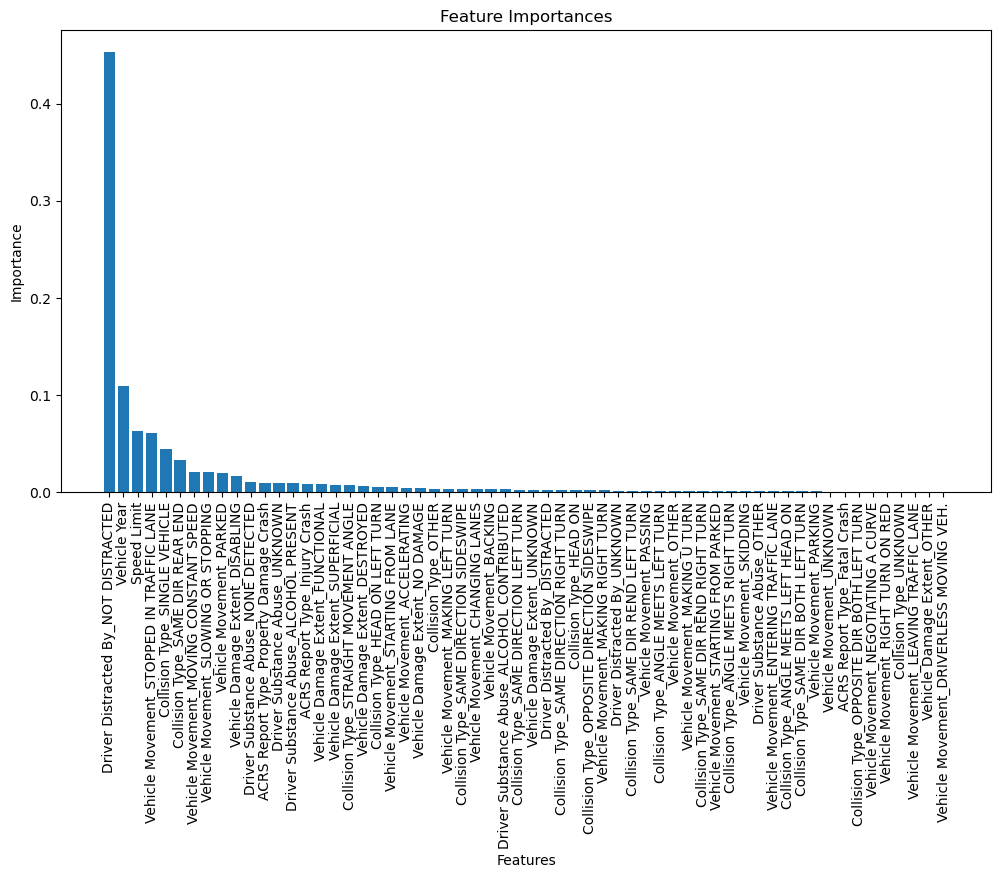

max_depth: 54
min_samples_split: 2
min_samples_leaf: 1
max_features None
criterion: gini


In [24]:
dec_tree_0 = DecisionTreeClassifier(random_state=10)

modelfit(dec_tree_0,X_train,y_train,printFeatureImportance=True)

decision_tree_params(dec_tree_0)

In [25]:
dec_tree_1 = DecisionTreeClassifier(max_depth=15,min_samples_split=60,random_state=10)

modelfit(dec_tree_1,X_train,y_train)


Model Report
Accuracy : 0.8679
AUC Score (Train): 0.941342
CV Score : Mean - 0.9291314 | Std - 0.002654461 | Min - 0.9258987 | Max - 0.9333148


In [26]:
dec_param_test_1 =  {'max_depth':range(14,30,2)}

gridSearch(dec_tree_1,dec_param_test_1,X_train,y_train)

Best Parameters: {'max_depth': 14}
Best Score: 0.9296392723620911


In [27]:
dec_tree_2 = DecisionTreeClassifier(max_depth=14,min_samples_split=60,random_state=10)

modelfit(dec_tree_2,X_train,y_train)


Model Report
Accuracy : 0.8656
AUC Score (Train): 0.939721
CV Score : Mean - 0.9292113 | Std - 0.002692164 | Min - 0.9254386 | Max - 0.9329492


In [28]:
dec_param_test_2 =  {'min_samples_split':range(40,81,2)}

gridSearch(dec_tree_2,dec_param_test_2,X_train,y_train)

Best Parameters: {'min_samples_split': 80}
Best Score: 0.9301112904553284



Model Report
Accuracy : 0.8652
AUC Score (Train): 0.939171
CV Score : Mean - 0.9300401 | Std - 0.002573119 | Min - 0.9260652 | Max - 0.9336529


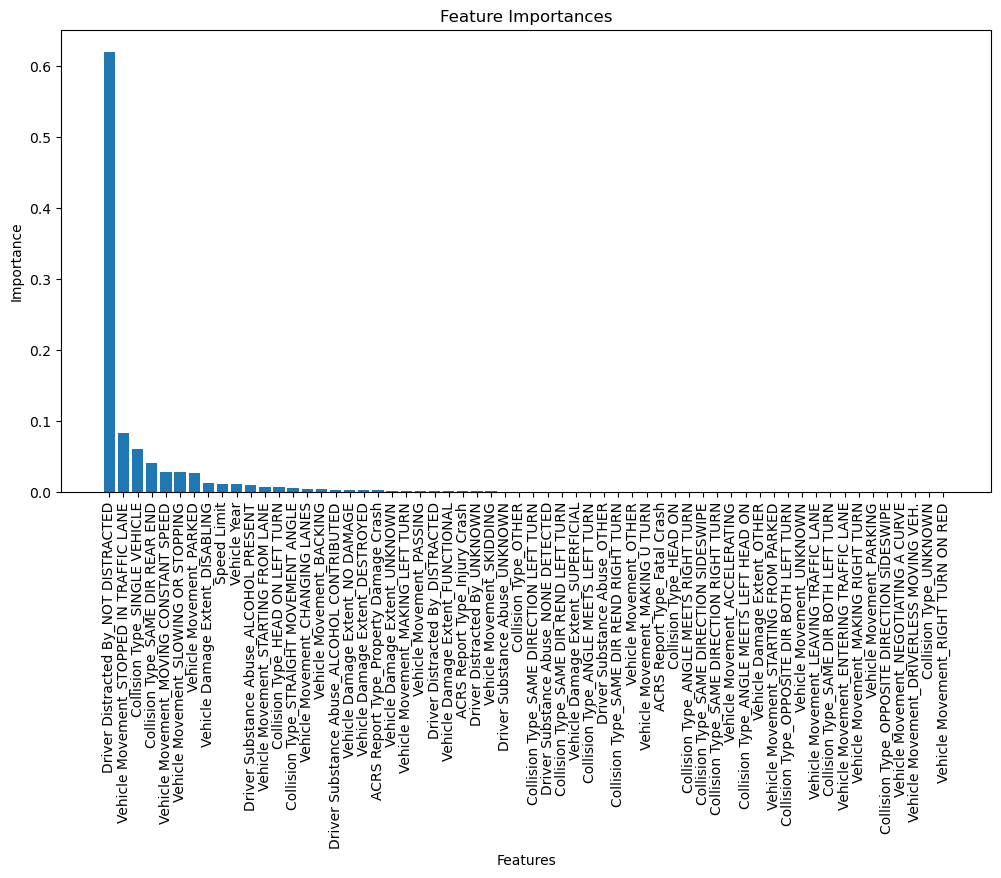

In [29]:
dec_tree_3 = DecisionTreeClassifier(max_depth=14,min_samples_split=80,random_state=10)

modelfit(dec_tree_3,X_train,y_train,printFeatureImportance=True)

## Gradient Boosting Classifier Model

In [30]:
from sklearn.ensemble import GradientBoostingClassifier


Model Report
Accuracy : 0.8574
AUC Score (Train): 0.933794
CV Score : Mean - 0.9330192 | Std - 0.002599062 | Min - 0.928468 | Max - 0.9367118


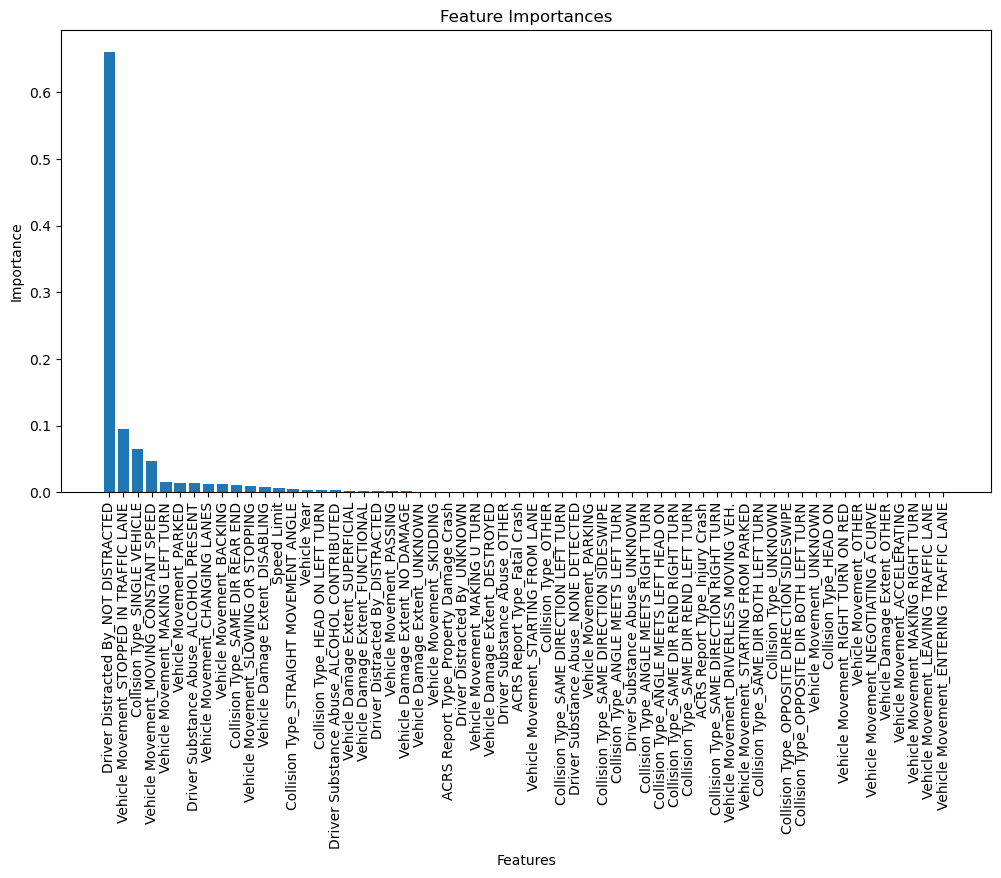

In [31]:
gbm0 = GradientBoostingClassifier(random_state=12)

modelfit(gbm0,X_train,y_train,printFeatureImportance=True)

In [32]:
gbm1 = GradientBoostingClassifier(min_samples_split= 1400,
                                   min_samples_leaf = 140,
                                   max_depth= 10,
                                   max_features = 'sqrt',
                                   subsample = 0.8,
                                   random_state=12)
modelfit(gbm1,X_train,y_train,cv_folds=5)


Model Report
Accuracy : 0.8675
AUC Score (Train): 0.939863
CV Score : Mean - 0.9378866 | Std - 0.001632613 | Min - 0.9361229 | Max - 0.940628


In [33]:
gbm_param_test_1 =  {'max_depth':range(8,31,2)}

gridSearch(gbm1, gbm_param_test_1,X_train,y_train,cv_folds=5)

Best Parameters: {'max_depth': 22}
Best Score: 0.9385908495544195


In [34]:
gbm2 = GradientBoostingClassifier(min_samples_split= 1400,
                                   min_samples_leaf = 140,
                                   max_depth= 22,
                                   max_features = 'sqrt',
                                   subsample = 0.8,
                                   random_state=12)
modelfit(gbm2,X,y,cv_folds=5)


Model Report
Accuracy : 0.8712
AUC Score (Train): 0.942274
CV Score : Mean - 0.9391107 | Std - 0.001069891 | Min - 0.9380506 | Max - 0.9407504


In [35]:
gbm_param_test_2 =  {'min_samples_split':range(1200,2001,200)}

gridSearch(gbm2, gbm_param_test_2,X_train,y_train,cv_folds=5)

Best Parameters: {'min_samples_split': 1400}
Best Score: 0.9385908495544195


In [36]:
gbm_param_test_3 =  {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}

gridSearch(gbm2, gbm_param_test_3,X_train,y_train,cv_folds=5)

Best Parameters: {'subsample': 0.85}
Best Score: 0.9387234473805387



Model Report
Accuracy : 0.8709
AUC Score (Train): 0.942455
CV Score : Mean - 0.9391334 | Std - 0.001104427 | Min - 0.9381623 | Max - 0.9409902


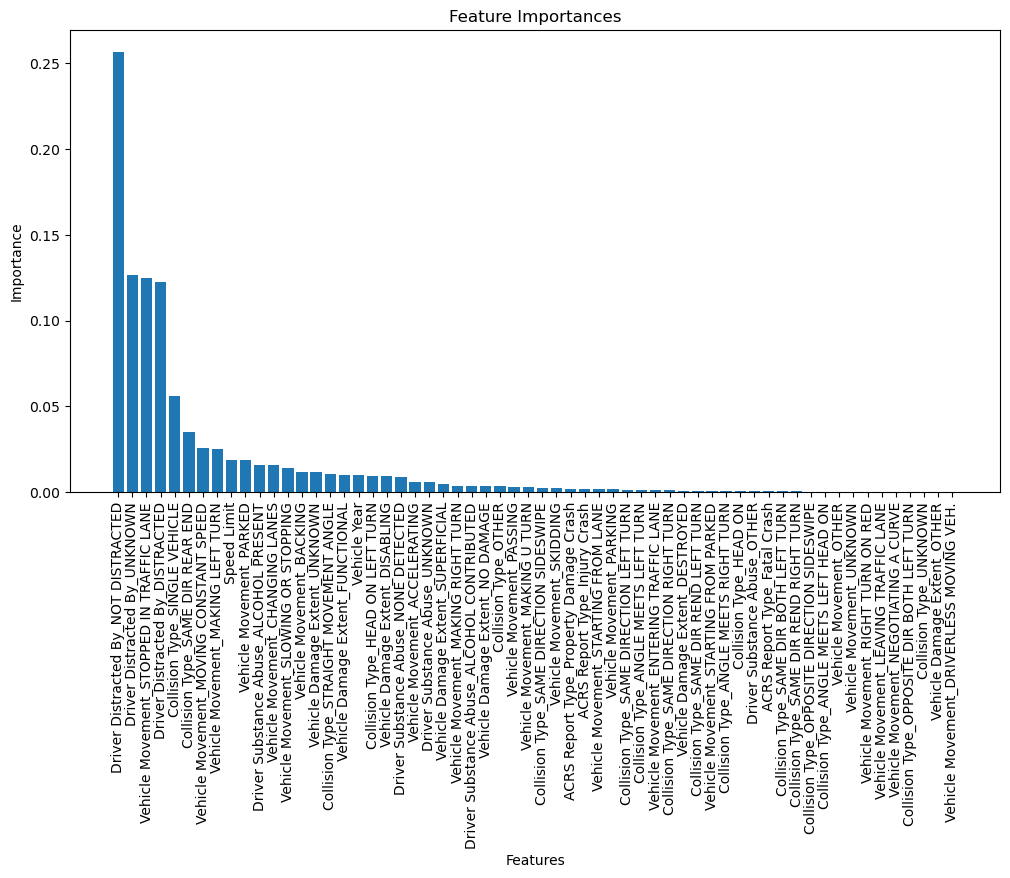

In [37]:
gbm3 = GradientBoostingClassifier(min_samples_split= 1400,
                                   min_samples_leaf = 140,
                                   max_depth= 22,
                                   max_features = 'sqrt',
                                   subsample = 0.85,
                                   random_state=12)
modelfit(gbm3,X,y,cv_folds=5,printFeatureImportance=True)

In [38]:
gbm4 = GradientBoostingClassifier( learning_rate = 0.05,
                                   n_estimators  = 200,
                                   min_samples_split= 1400,
                                   min_samples_leaf = 140,
                                   max_depth= 22,
                                   max_features = 'sqrt',
                                   subsample = 0.9,
                                   random_state=12)
modelfit(gbm4,X_train,y_train,cv_folds=5)


Model Report
Accuracy : 0.8712
AUC Score (Train): 0.942731
CV Score : Mean - 0.9389273 | Std - 0.00156627 | Min - 0.9372496 | Max - 0.9414548


# Models Evaluation

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
y_pred_dec_tree = dec_tree_3.predict(X_test)

In [41]:
y_pred_grad_boost = gbm3.predict(X_test)

### Confusion Matrix

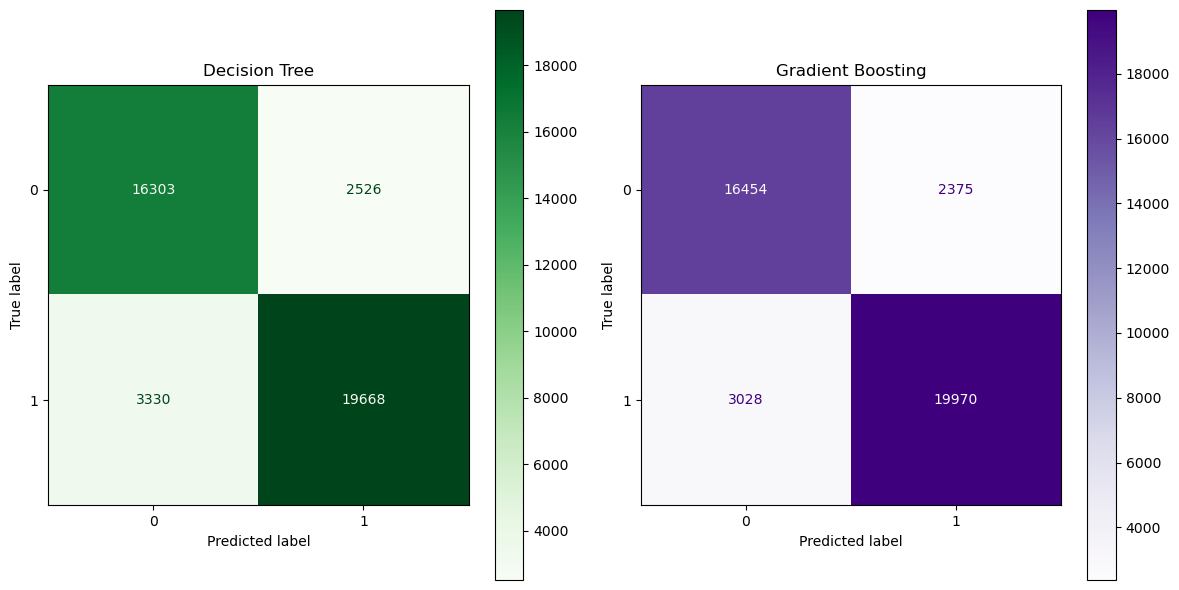

In [42]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first confusion matrix (Decision Tree)
cm_tree = confusion_matrix(y_test, y_pred_dec_tree, labels=dec_tree_3.classes_)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=dec_tree_3.classes_)
disp_tree.plot(cmap="Greens", values_format='', ax=ax1)
ax1.set_title('Decision Tree')

# Plot the second confusion matrix (Gradient Boosting)
cm_gbm = confusion_matrix(y_test, y_pred_grad_boost, labels=gbm3.classes_)
disp_gbm = ConfusionMatrixDisplay(confusion_matrix=cm_gbm, display_labels=gbm3.classes_)
disp_gbm.plot(cmap="Purples", values_format='', ax=ax2)
ax2.set_title('Gradient Boosting')

# Adjust layout
plt.tight_layout()
plt.show()

In [43]:
ax.set_title('Decision Tree')
plt.show()
plt.savefig('confusion_matrix_decision_tree.png')

<Figure size 640x480 with 0 Axes>

### Classification Report

In [44]:
print("\033[1mDecision Tree Model:\033[0m\n\n", metrics.classification_report(y_test, y_pred_dec_tree, digits=6))
print("\033[1mGradient Boosting Model:\033[0m\n\n",metrics.classification_report(y_test, y_pred_grad_boost, digits=6))

Decision Tree Model:

               precision    recall  f1-score   support

           0   0.830388  0.865845  0.847746     18829
           1   0.886185  0.855205  0.870420     22998

    accuracy                       0.859995     41827
   macro avg   0.858287  0.860525  0.859083     41827
weighted avg   0.861067  0.859995  0.860213     41827

Gradient Boosting Model:

               precision    recall  f1-score   support

           0   0.844574  0.873865  0.858970     18829
           1   0.893712  0.868336  0.880842     22998

    accuracy                       0.870825     41827
   macro avg   0.869143  0.871101  0.869906     41827
weighted avg   0.871592  0.870825  0.870996     41827



### ROC-AUC

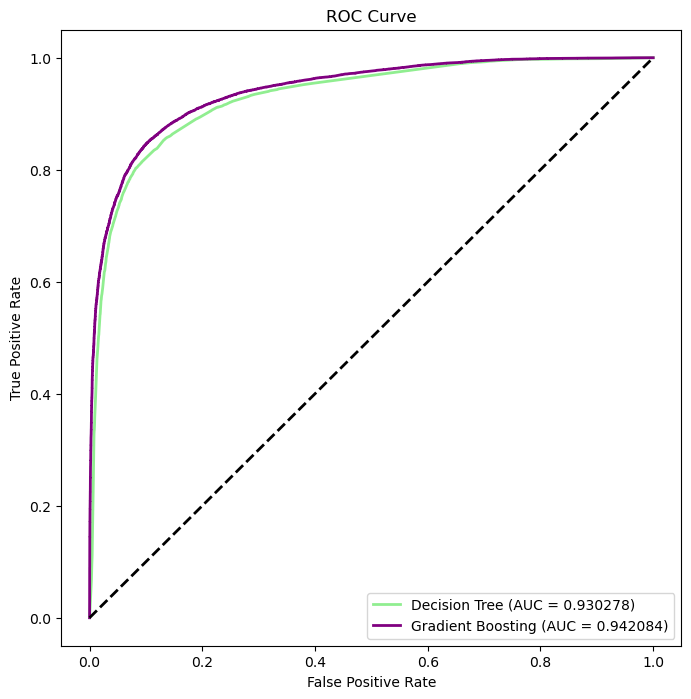

In [45]:
y_pred_prob_dec_tree   = dec_tree_3.predict_proba(X_test)[:,1]
y_pred_prob_grad_boost = gbm3.predict_proba(X_test)[:,1]

# Compute ROC curve and ROC area for the Decision Tree model
fpr_dec_tree, tpr_dec_tree, _ = metrics.roc_curve(y_test, y_pred_prob_dec_tree)
roc_auc_dec_tree = metrics.auc(fpr_dec_tree, tpr_dec_tree)

# Compute ROC curve and ROC area for the Gradient Boosting model
fpr_grad_boost, tpr_grad_boost, _ = metrics.roc_curve(y_test, y_pred_prob_grad_boost)
roc_auc_grad_boost = metrics.auc(fpr_grad_boost, tpr_grad_boost)

# Plot ROC curve for both models
plt.figure(figsize=(8, 8))
plt.plot(fpr_dec_tree, tpr_dec_tree, color='lightgreen', lw=2, label=f'Decision Tree (AUC = {roc_auc_dec_tree:.6f})')
plt.plot(fpr_grad_boost, tpr_grad_boost, color='purple', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_grad_boost:.6f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
